In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial
from einops import rearrange
import gymnasium as gym
import gym as gym_old
from tqdm.auto import tqdm
import procgen
import cv2
import os
# from ppo import *

In [4]:
class MinerActionRestriction(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_space = gym.spaces.Discrete(4)
        udlr = {'UP', 'DOWN', 'LEFT', 'RIGHT'}
        self.possible_actions = []
        for i, action in enumerate(env.unwrapped.env.env.combos):
            if len(action)==0 or (len(action)==1 and action[0] in udlr):
                self.possible_actions.append(i)
    def step(self, action):
        return self.env.step(self.possible_actions[action])

class RescaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        os = env.observation_space
        self.observation_space = gym.spaces.Box(low=os.low, high=os.high/255., shape=os.shape, dtype=np.float32)
    def observation(self, obs):
        return (obs/255.).astype(np.float32)

In [ ]:
envs = gym.wrappers.RecordEpisodeStatistics(envs)
if args.capture_video:
    envs = gym.wrappers.RecordVideo(envs, f"videos/{run_name}")
envs = gym.wrappers.NormalizeReward(envs, gamma=args.gamma)
envs = gym.wrappers.TransformReward(envs, lambda reward: np.clip(reward, -10, 10))

In [5]:
class MyProcgenEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        os = env.observation_space
        self.observation_space = gym.spaces.Box(low=os.low, high=os.high, shape=os.shape, dtype=np.float32)
        self.action_space = gym.spaces.Discrete(env.action_space.n)

        self.last_obs = None

    def __getattr__(self, name: str):
        if name=='render_mode':
            return 'rgb_array'
        return super().__getattr__(name)

    def reset(self, *args, **kwargs):
        obs = self.env.reset()
        self.last_obs = obs
        return obs, {}

    def step(self, *args, **kwargs):
        obs, reward, done, info = self.env.step(*args, **kwargs)
        self.last_obs = obs
        return obs, reward, done, False, info
    
    def render(self):
        return self.last_obs

def make_single_env(env_name='procgen-miner-v0', level_id=0, seed=0, video_folder=None):
    env = gym_old.make(env_name, num_levels=1, start_level=level_id, distribution_mode='hard')
    env = MyProcgenEnv(env)
    if video_folder is not None:
        env = gym.wrappers.RecordVideo(env, video_folder)
    env = MinerActionRestriction(env)
    env = RescaleObservation(env)
    # env = gym.wrappers.FrameStack(env, 4)
    # env = gym.wrappers.RecordEpisodeStatistics(env)
    env.observation_space.seed(seed)
    env.action_space.seed(seed)
    return env

def make_env(n_envs=10, env_name='procgen-miner-v0', level_id=0, video_folder=None):
    env_fns = [partial(make_single_env, env_name=env_name, level_id=level_id,
                       seed=seed, video_folder=video_folder if seed==0 else None) for seed in range(n_envs)]
    env =  gym.vector.SyncVectorEnv(env_fns)
    return env

In [9]:
import testing_ppo
import  models

In [14]:
env = make_env(64)
agent = models.Agent(env)
parser = testing_ppo.parse_args()
args = parser.parse_args(''.split())

In [15]:
testing_ppo.run(agent, env, args)

KeyboardInterrupt: 

In [74]:
env = gym_old.make('procgen-miner-v0', num_levels=1, start_level=0)
env = MyProcgenEnv(env)

env.reset()
for i in range(1100):
    obs, _, term, trunc, _ = env.step(4)
    if term or trunc:
        break
print(i)


999


0
('LEFT', 'DOWN')


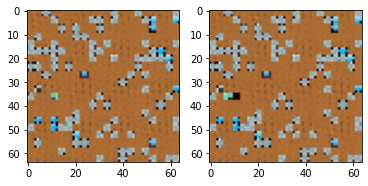

1
('LEFT',)


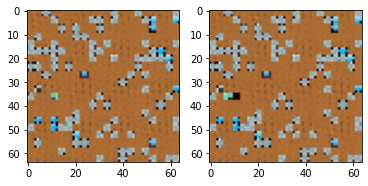

2
('LEFT', 'UP')


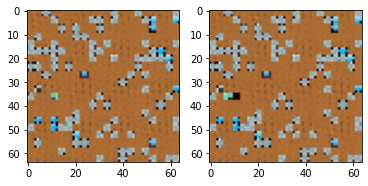

3
('DOWN',)


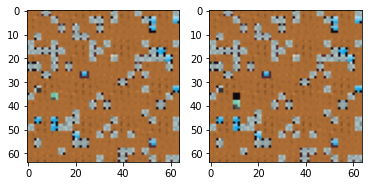

4
()


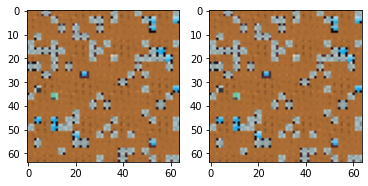

5
('UP',)


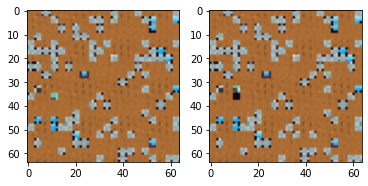

6
('RIGHT', 'DOWN')


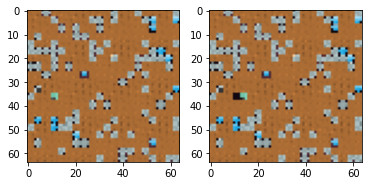

7
('RIGHT',)


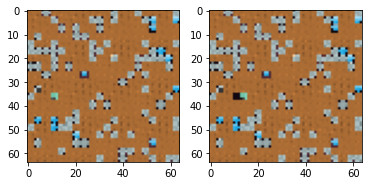

8
('RIGHT', 'UP')


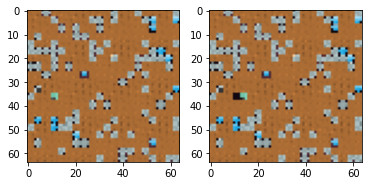

9
('D',)


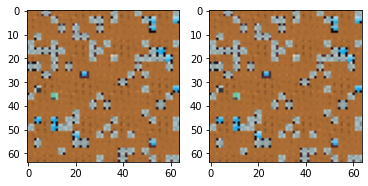

10
('A',)


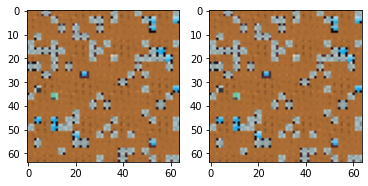

11
('W',)


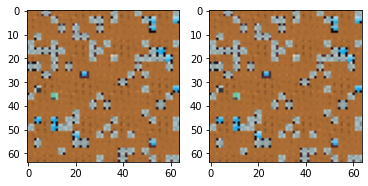

12
('S',)


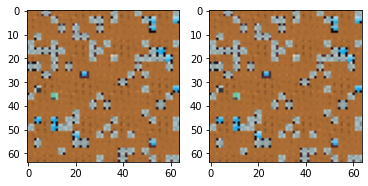

13
('Q',)


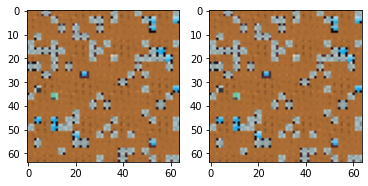

14
('E',)


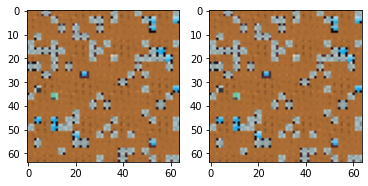

In [55]:
for action in range(env.action_space.n):
    env = gym_old.make('procgen-miner-v0', num_levels=1, start_level=0)
    env = MyProcgenEnv(env)
    print(action)
    print(env.unwrapped.env.env.combos[action])
    obs, info = env.reset()
    plt.subplot(121)
    plt.imshow(obs)
    obs, _, _, _, _ = env.step(action)
    plt.subplot(122)
    plt.imshow(obs)
    plt.show()